In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus import Surface
from olympus.campaigns import ParameterSpace, Campaign
from olympus.objects import ParameterContinuous
from atlas.planners.gp.planner import GPPlanner
from atlas.unknown_constraints.benchmark_functions import BraninConstr

sns.set(style='ticks', context='notebook', font_scale=1.2)
from cmcrameri import cm


In [37]:
# Golem colormap
_reference_colors = ['#008080', '#70a494', '#b4c8a8', '#f6edbd', '#edbb8a', '#de8a5a','#ca562c']
_cmap = LinearSegmentedColormap.from_list('golem', _reference_colors)
_cmap_r = LinearSegmentedColormap.from_list('golem_r', _reference_colors[::-1])
# plt.register_cmap(cmap=_cmap)
# plt.register_cmap(cmap=_cmap_r)

cmap = cm.nuuk

def get_golem_colors(n):
    _cmap = plt.get_cmap('golem')
    return [_cmap(x) for x in np.linspace(0, 1, n)]

def plot_contour(ax, X0, X1, y, xlims, ylims, vlims=[None, None], alpha=0.5, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_color='k', contour_alpha=1, cbar=False, cmap=cmap):
    # background surface
    if contour_lines is True:
        contours = ax.contour(X0, X1, y, n_contour_lines, colors=contour_color, alpha=contour_alpha, linestyles='dashed')
        if contour_labels is True:
            _ = ax.clabel(contours, inline=True, fontsize=labels_fs, fmt=labels_fmt)
    mappable = ax.imshow(y, extent=[xlims[0],xlims[1],ylims[0],ylims[1]], 
                         origin='lower', cmap=cmap, alpha=alpha, vmin=vlims[0], vmax=vlims[1])
    
    if cbar is True:
        cbar = plt.colorbar(mappable=mappable, ax=ax, shrink=0.5)
        
    return mappable

def plot_constr_surface(surface, ax=None, N=100):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

    x0 = np.linspace(0,1,N)
    x1 = np.linspace(0,1,N)
    X0, X1 = np.meshgrid(x0,x1)
    X = np.array([X0.flatten(), X1.flatten()]).T
    y = np.array(surface.run(X)).flatten()
    Y = np.reshape(y, newshape=np.shape(X0))

    _ = plot_contour(ax, X0, X1, Y, xlims=[0,1], ylims=[0,1], alpha=1, contour_lines=True, contour_labels=True, 
                 labels_fs=8, labels_fmt='%d', n_contour_lines=8, contour_alpha=0.8, cbar=False, cmap=cmap) #'golem'
    for param in surface.minima:
        x_min = param['params']
        ax.scatter(x_min[0], x_min[1], s=200, marker='*', color='#ffc6ff', zorder=20)
    
    y_feas = np.array(surface.eval_constr(X))
    Y_feas = np.reshape(y_feas, newshape=np.shape(X0))
    ax.imshow(Y_feas, extent=[0,1,0,1], origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    
def plot_constr_surface_cat(surface, ax=None, mark_min=False):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
        
        
    domain = np.arange(21)
    Z = np.zeros((21, 21))
    Z_feas = np.empty((21, 21))
    X = []
    for x_index, x in enumerate(domain):
        for y_index, y in enumerate(domain):
            x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
            X.append(x)
            loss_value = surface.run(x)
            feas_bool = surface.eval_constr([x])
            Z[y_index, x_index] = loss_value
            #print(loss_value)
            #print(feas_bool)
            #print(x)
            Z_feas[y_index, x_index] = all(feas_bool)
            
    # scale Camel for visualization 
    if type(surface).__name__ == 'CatCamelConstr':
        Z = np.log(Z)

    ax.imshow(Z, origin='lower', cmap = cmap)
    #ax.imshow(Z_feas, origin='lower', cmap='gray', alpha=0.5, interpolation='none')
    
    if mark_min is True:
        X_best = surface.str2array(surface.best)
        _ = ax.scatter(X_best[0], X_best[1], marker='*', s=200, color='#ffc6ff', linewidth=2, zorder=20)
        
        
def plot_constr_surface_with_scatter(ax, surface, data, repeat=0):

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    plot_constr_surface(surface, ax=ax, N=100)

    repeat = 0
    X = data[repeat].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    # mask = np.array([surface.is_feasible(x) for x in X])
    X_feas = X[mask]
    X_infs = X[~mask]

    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    
def calc_frac_feasible(surface, N=10000, categorical=False):
    if categorical is False:
        X = np.random.uniform(0, 1, size=(N, 2))
        y_feas = np.array(surface.eval_constr(X))
    else:
        domain = np.arange(surface.num_opts)
        y_feas = []
        for x_index, x in enumerate(domain):
            for y_index, y in enumerate(domain):
                x = ['x_{}'.format(x_index), 'x_{}'.format(y_index)]
                feas_bool = surface.eval_constr(x)
                y_feas.append(feas_bool)
    return sum(y_feas) / len(y_feas)


def plot_binary_scatter(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas = X[mask]
    X_infs = X[~mask]
    
    ax.scatter(X_feas['x0'], X_feas['x1'], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs['x0'], X_infs['x1'], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

    
def plot_binary_scatter_cat(surface, pkl_file, ax, n=0):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    X = data[n].loc[:, ['x0', 'x1']]
    mask = surface.eval_constr(X.to_numpy())
    X_feas_ = X[mask].values
    X_infs_ = X[~mask].values
    
    X_feas = []
    for x_ in X_feas_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_feas.append(x)
    
    X_infs = []
    for x_ in X_infs_:
        x = [int(x_[0][2:]), int(x_[1][2:])]
        X_infs.append(x)

    X_infs = np.array(X_infs)
    X_feas = np.array(X_feas)
    
    ax.scatter(X_feas[:,0], X_feas[:,1], marker='X', s=100, color='#adb5bd', edgecolor='k', zorder=10)
    ax.scatter(X_infs[:,0], X_infs[:,1], marker='X', s=100, color='white', edgecolor='k', zorder=10)
    

In [38]:
def get_traces_min(data, replace_nan=True):
    traces_min = []
    for df in data:
        trace = df.loc[:, 'obj'].to_numpy()
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
    return np.array(traces_min)

def plot_min_trace_mean(
    data, ax=None, color=None, label=None, categorical=False, stde=False, unc=True, shift=0.0, maximize=False,
    linewidth=4, 
):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
    
    if not maximize:
        if categorical is True:
            traces_min = get_traces_min_for_categorical(data) - shift
        else:
            traces_min = get_traces_min(data) - shift
    else:
        traces_min = get_traces_max(data)-shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=linewidth+1)
    plot_ = ax.plot(x, mean, color=color, linewidth=linewidth, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    return plot_

        

## Plot results

In [50]:
# loop through file names
# read result files
all_df = {}
for fname in glob('results_*.pkl'):
    tag = fname.split('_')[-1].split('.pkl')[0]
    list_df = []
    for i, df in enumerate(pickle.load(open(fname, 'rb'))):
        df = df.rename(columns={'param_0': 'x0',  'param_1': 'x1'})
        df['run'] = i
        df['strategy'] = tag
        list_df.append(df)
    all_df[tag] = list_df

# print out one example
all_df['naive-0'][0].head()

,x0,x1,obj,run,strategy
0,0.563341,0.125465,0.878391,0,naive-0
1,0.752248,0.577326,76.753774,0,naive-0
2,0.967848,0.214120,NaN,0,naive-0
3,0.070796,0.081372,173.601372,0,naive-0
4,0.043929,0.416076,89.368416,0,naive-0


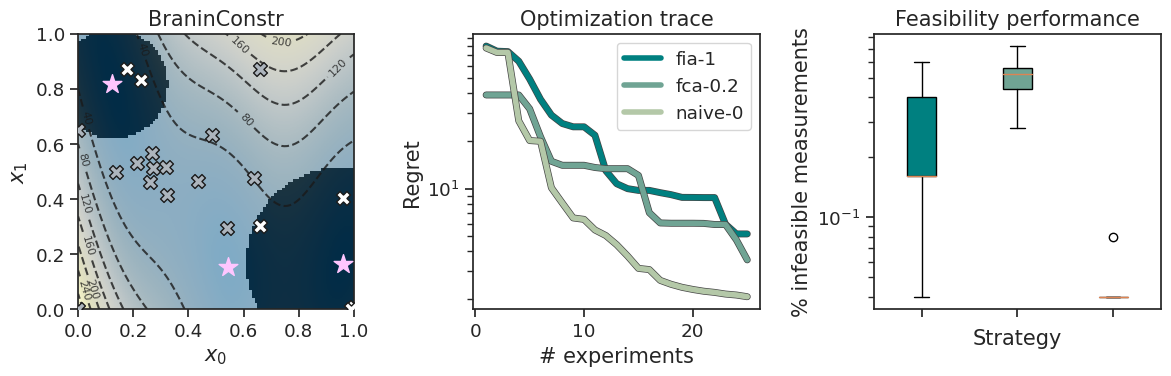

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plain surface
surface = BraninConstr()

# surface with observations
plot_constr_surface_with_scatter(axes[0], surface, all_df['fca-0.2'], repeat=0)
axes[0].set_xlabel(r'$x_0$', fontsize=15)
axes[0].set_ylabel(r'$x_1$', fontsize=15)
axes[0].set_title('BraninConstr', fontsize=15)


# optimization trace
all_feas = {}
for i, (k, v) in enumerate(all_df.items()):
    plot_min_trace_mean(
        v, ax=axes[1], color=_reference_colors[i], label=k, 
        categorical=False, stde=False, unc=False, 
        shift=surface.minima[0]['value'], maximize=False,
        linewidth=4, 
    )

    all_feas[k] = [df['obj'].isna().sum() / len(df) for df in v]

axes[1].set_yscale('log')
axes[1].legend(loc='upper right')
axes[1].set_xlabel('# experiments', fontsize=15)
axes[1].set_ylabel('Regret', fontsize=15)
axes[1].set_title('Optimization trace', fontsize=15)

boxplot = axes[2].boxplot(
    list(all_feas.values()), patch_artist=True
)

for i, patch in enumerate(boxplot['boxes']):
    patch.set_facecolor(_reference_colors[i])

# axes[2].legend(loc='upper right')
axes[2].set_yscale('log')
axes[2].set_xlabel('Strategy', fontsize=15)
axes[2].set_ylabel('% infeasible measurements', fontsize=15)
axes[2].set_title('Feasibility performance', fontsize=15)
axes[2].set_xticklabels([])

plt.tight_layout()
plt.savefig('constrained_braninconstr.png', dpi=300)